### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/HW2

/gdrive/My Drive/HW2


### Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)


Load the dataset

In [5]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


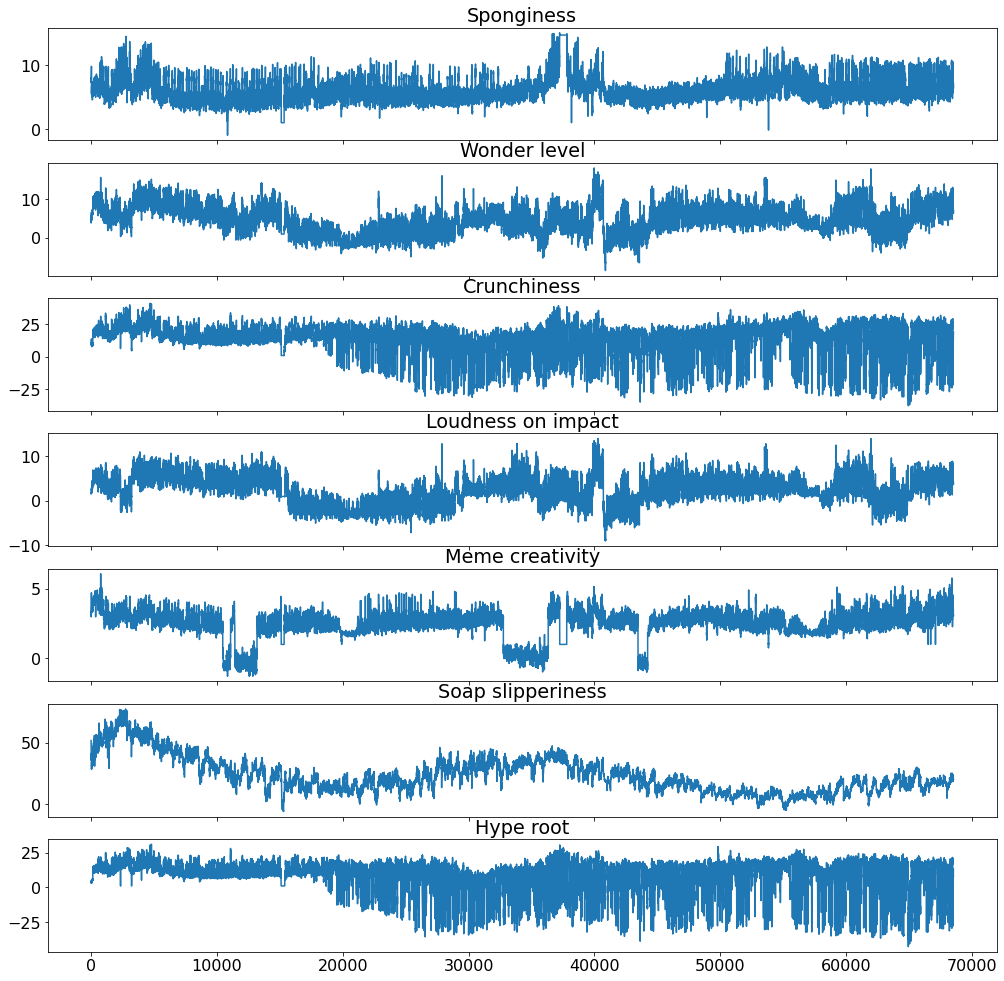

In [7]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

(68528, 7)


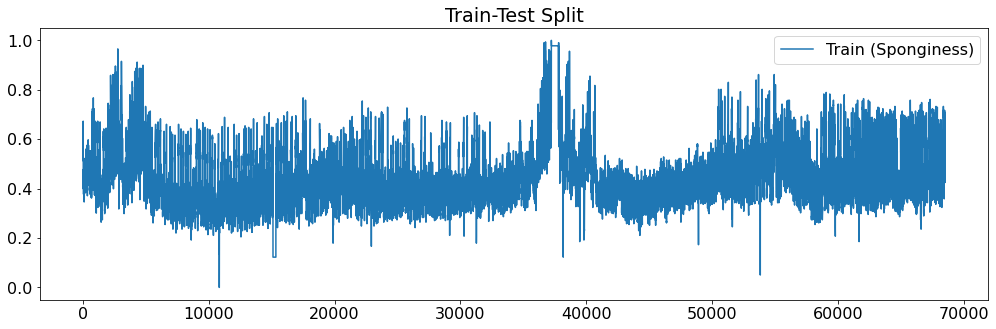

In [8]:
# test_size = 8528
X_train_raw = dataset.iloc[:]
# y_train_raw = y.iloc[:-test_size]
# X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
# X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
# plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [9]:
window = 576
stride = 6
telescope = 288
target_labels = dataset.columns

In [10]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

### Multivariate Forecasting (Autoregression)

In [11]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
# X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape

((11280, 576, 7), (11280, 288, 7))

In [12]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

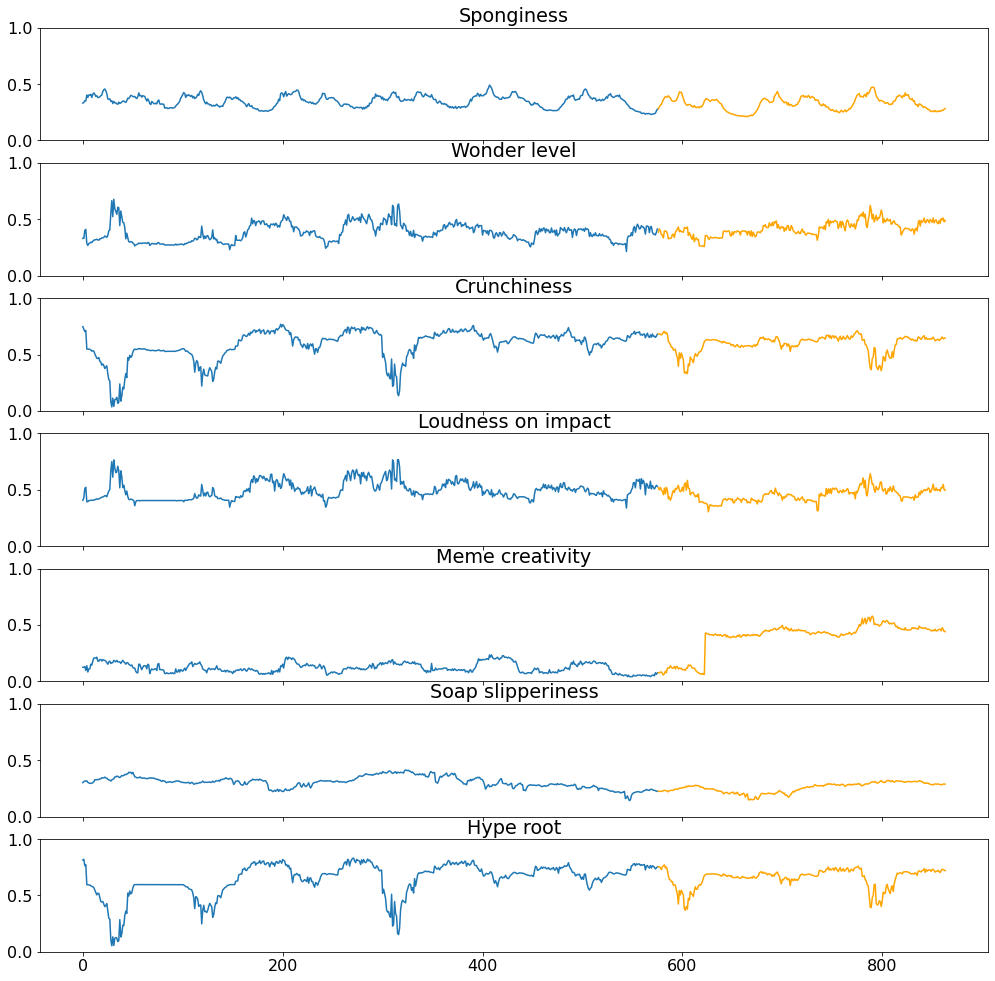

In [13]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [14]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [15]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.Bidirectional(tfkl.LSTM(256, kernel_initializer=tfk.initializers.GlorotUniform(seed),return_sequences=True))(input_layer)
    lstm = tfkl.Bidirectional(tfkl.LSTM(256, kernel_initializer=tfk.initializers.GlorotUniform(seed),return_sequences=True))(lstm)
    lstm = tfkl.Bidirectional(tfkl.LSTM(256, kernel_initializer=tfk.initializers.GlorotUniform(seed)))(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], kernel_initializer=tfk.initializers.GlorotUniform(seed),activation='relu')(dropout)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=tfk.metrics.RootMeanSquaredError())

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 576, 7)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 576, 512)         540672    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 576, 512)         1574912   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

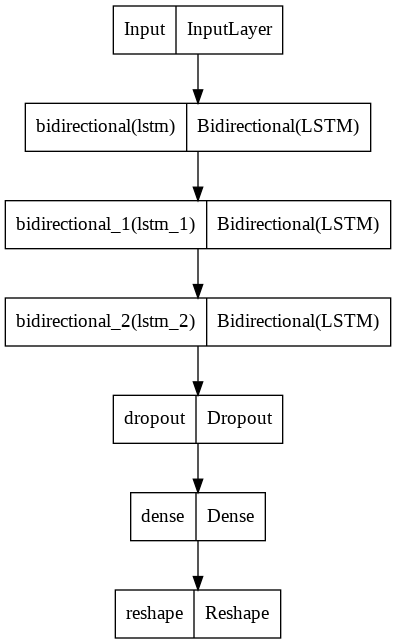

In [16]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [17]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
159/159 [==============================] - 71s 380ms/step - loss: 0.0291 - root_mean_squared_error: 0.1705 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1316 - lr: 0.0010
Epoch 2/200
159/159 [==============================] - 61s 381ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096 - lr: 0.0010
Epoch 3/200
159/159 [==============================] - 62s 389ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1032 - lr: 0.0010
Epoch 4/200
159/159 [==============================] - 63s 395ms/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007 - lr: 0.0010
Epoch 5/200
159/159 [==============================] - 63s 397ms/step - loss: 0.0088 - root_mean_squared_error: 0.0938 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1022 - lr: 0.0010
Epoch 6/200
159/159 [==============================] - 

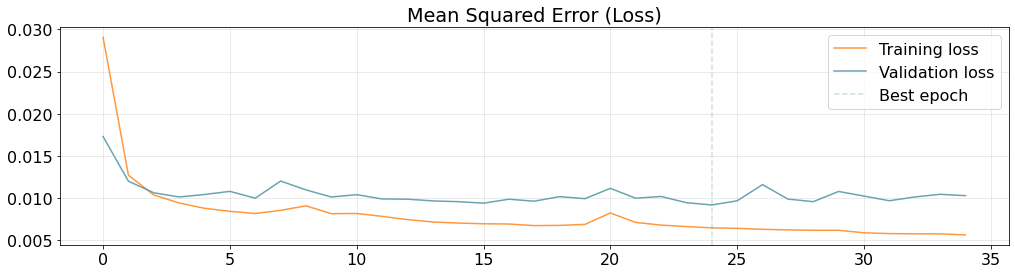

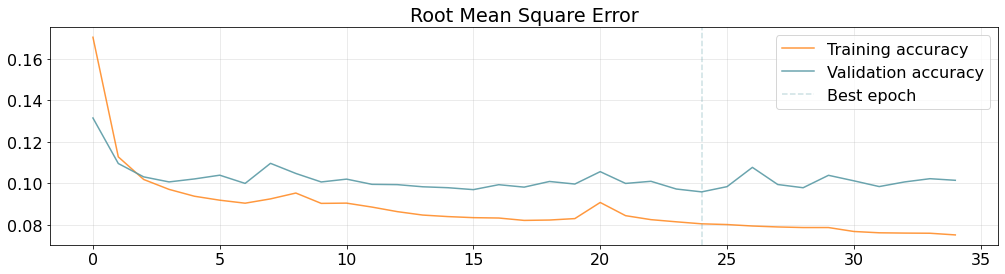

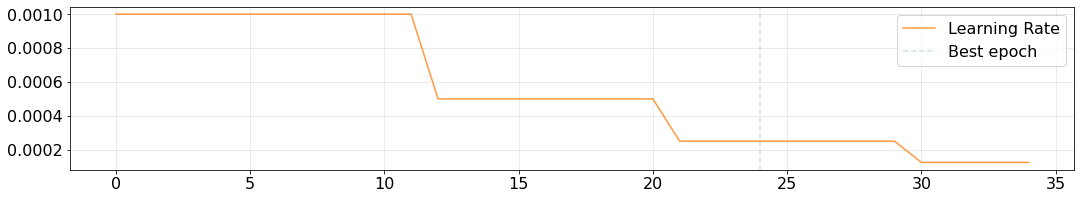

In [18]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['root_mean_squared_error'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_root_mean_squared_error'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Root Mean Square Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [19]:
model.save('HW2-Auto-12-01')
model = tfk.models.load_model('HW2-Auto-12-01')

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
root_mean_squared_error = mean_squared_error**(0.5)
mean_squared_error, root_mean_squared_error

(648, 288, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.011376414>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.10666027>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

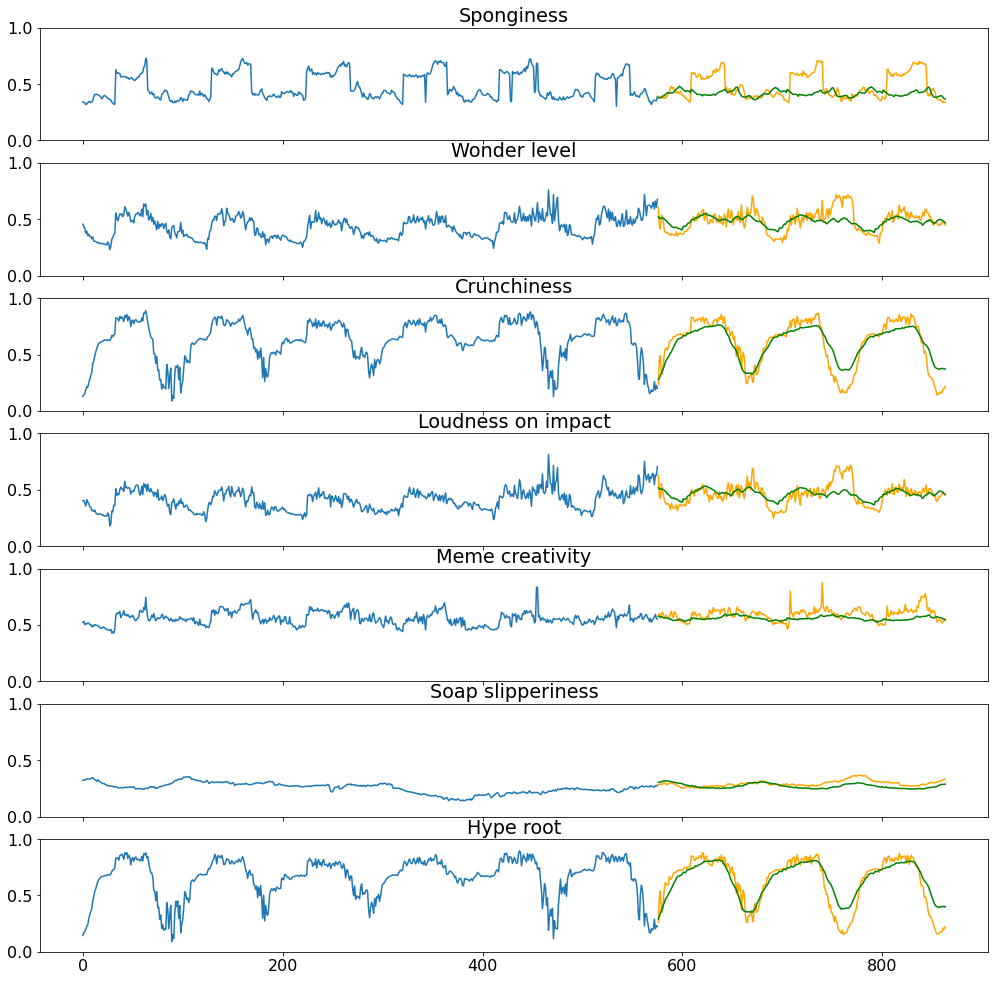

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [ ]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((600, 576, 7), (600, 864, 7))

In [ ]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [ ]:
reg_predictions.shape

(600, 864, 7)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
root_mean_squared_error = mean_squared_error**(0.5)
mean_squared_error, root_mean_squared_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.012473103>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.111683056>)

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

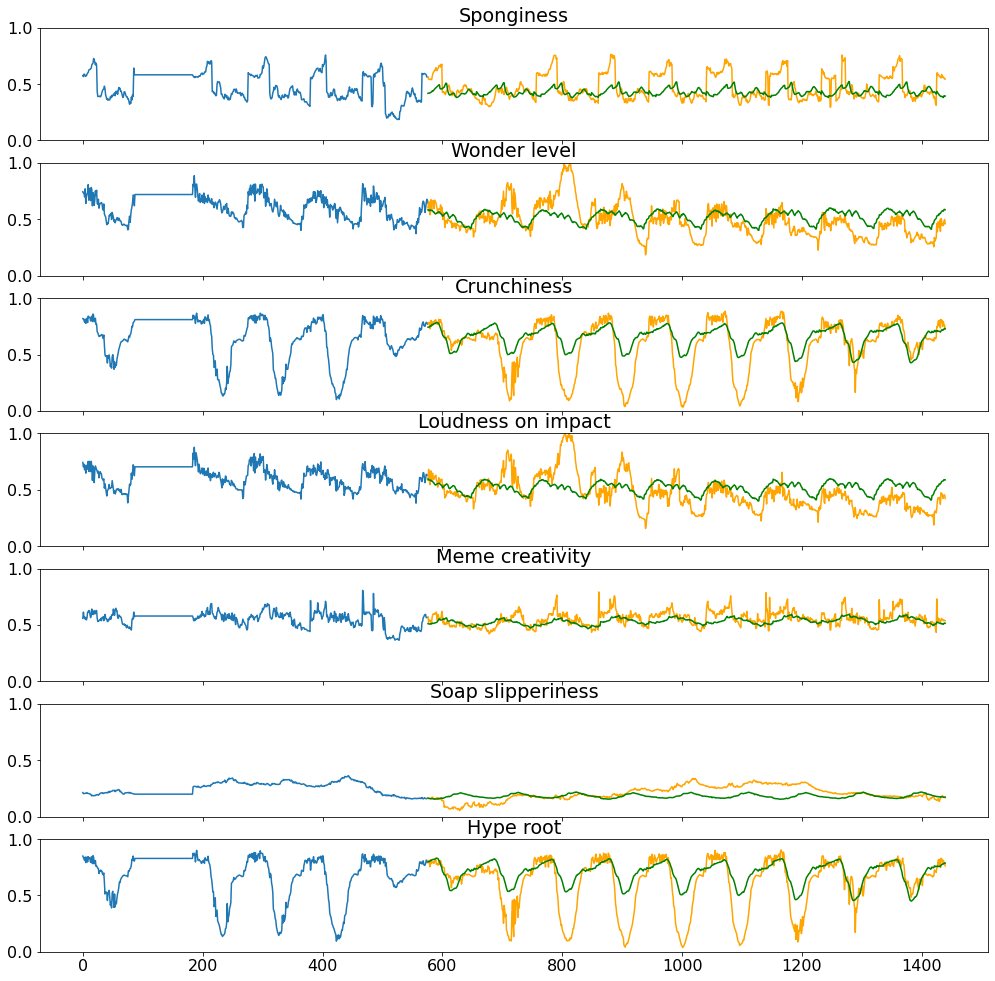

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)